## Prepare

In [ ]:
! pip install -r requirements.txt

In [ ]:
! wget -O dacapo-bench.jar https://downloads.sourceforge.net/project/dacapobench/9.12-bach-MR1/dacapo-9.12-MR1-bach.jar?ts=gAAAAABk1grVPN66UoxuyfsRPvuzhgnmeEB0y0aRIsA3TRrksaUWqajBjQ-E21zbKyJzhrCcIYFh6YpJanCBPWJlAoXzemk3Rg%3D%3D&r=https%3A%2F%2Fsourceforge.net%2Fprojects%2Fdacapobench%2Ffiles%2F9.12-bach-MR1%2Fdacapo-9.12-MR1-bach.jar
# ! wget -O jdk.tar.gz https://download.bell-sw.com/java/11.0.20+8/bellsoft-jdk11.0.20+8-linux-amd64.tar.gz
# MACOS
# ! wget -O jdk.tar.gz https://download.bell-sw.com/java/11.0.20.1+1/bellsoft-jdk11.0.20.1+1-macos-amd64.tar.gz
! wget -O jdk.zip https://download.bell-sw.com/java/11.0.20.1+1/bellsoft-jdk11.0.20.1+1-windows-amd64.zip
# ! wget https://sourceforge.net/projects/gcviewer/files/gcviewer-1.36.jar/download
# ! tar xzf jdk.tar.gz && rm -fv jdk.tar.gz
! java -version

In [17]:
! java -jar dacapo-bench.jar -l

avrora batik eclipse fop h2 jython luindex lusearch lusearch-fix pmd sunflow tomcat tradebeans tradesoap xalan


In [ ]:
! ./jdk-11.0.20.1.jdk/bin/java -XX:+UseParallelGC -Xmx4g -Xms128m  -cp dacapo-bench.jar \
-Xlog:gc=debug:file=gc-batik.txt -Dvmstat.enable_jfr=yes \
-Dvmstat.csv=yes Harness -v -n 5 batik

In [ ]:
# ! pip install gym
# ! mkdir /home/ellkrauze/tmp
# ! export TMPDIR=/home/ellkrauze/tmp && pip install tensorflow
# ! export TMPDIR=/home/ellkrauze/tmp && pip install protobuf==3.20.*
# ! export TMPDIR=/home/ellkrauze/tmp && pip  install --force-reinstall -U tensorflow==2.3.0 keras keras-rl2 h5py==2.10.*


### GCViewer

In [ ]:
# Download jar from http://sourceforge.net/projects/gcviewer/files/gcviewer-1.36.jar/download
# java -cp gcviewer-1.36.jar com.tagtraum.perf.gcviewer.GCViewer gc-xalan.txt summary.csv -t SUMMARY

## Main

In [ ]:
! python -V

Python 3.9.13


In [ ]:
! export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

import requests
import json
import logging
import warnings
import numpy as np
from typing import List
from gym.spaces import Discrete, Box
import JVMEnv, JVMEnvTest
from tqdm import tqdm 

warnings.filterwarnings(action="ignore")

# GCEasy API Key
API_KEY = "af176fbc-7be2-4fc5-8b31-5624956845c6"

# JDK used for benchmarking
TEST_JDK_PATH = "/home/ellkrauze/projects/gc-ml/jdk-11.0.20"

# DaCapo benchmark name
BM = "batik"

BM_PATH = "dacapo-bench.jar"

# Number of benchmark's iterations in total
NUM_ITER = 5

# Name of the output file (Garbage Collector logs)
GC_LOG_FILE = f"gc-{BM}.txt"

# JVM option to perform action to (increase, leave, decrease)
JVM_OPT_NAME = "MaxHeapSize"
# Maximum heap size array (from 256m to 4G)
JVM_OPT_RANGE = [np.array([268435456]), np.array([4294967296])]

"""
What to optimize: our goal in performance tuning.
This is a JSON field which is extracted from GC log file
using GCEasy API (https://blog.gceasy.io/2016/06/18/garbage-collection-log-analysis-api/).
"""
# GOAL = "throughputPercentage"
GOAL = "fullGCMaxTime"


In [ ]:
# env = JVMEnv.JVMEnv(
#     jdk = TEST_JDK_PATH, 
#     bm_path = BM_PATH,
#     jvm_opt_name = JVM_OPT_NAME,
#     jvm_opt_range = JVM_OPT_RANGE,
#     bm = BM,
#     n = NUM_ITER,
#     goal = GOAL,
#     api_key = API_KEY
# )

## Plot Xmx

In [ ]:

fullgc_values = []
minorgc_values = []
heap_values = []

for Xmx in tqdm(range(268435456, 4294967296, 100 * (2**10) * (2**10))):
    env._run(
        jvm_opts = [f"-XX:MaxHeapSize={Xmx}"], 
        gc_log_file = GC_LOG_FILE, 
        bm = BM, 
        bm_path = BM_PATH, 
        n = NUM_ITER
    )
    
    fullgc_value = env._get_goal_value(
        goal_name = "fullGCMaxTime", 
        gc_log_file = GC_LOG_FILE, 
        api_key = API_KEY
    )

    minorgc_value = env._get_goal_value(
        goal_name = "minorGCMaxTime", 
        gc_log_file = GC_LOG_FILE, 
        api_key = API_KEY
    )

    fullgc_values.append(fullgc_value)
    minorgc_values.append(minorgc_value)
    heap_values.append(Xmx)

100%|██████████| 39/39 [06:48<00:00, 10.47s/it]


100%|██████████| 39/39 [01:50<00:00,  2.83s/it]


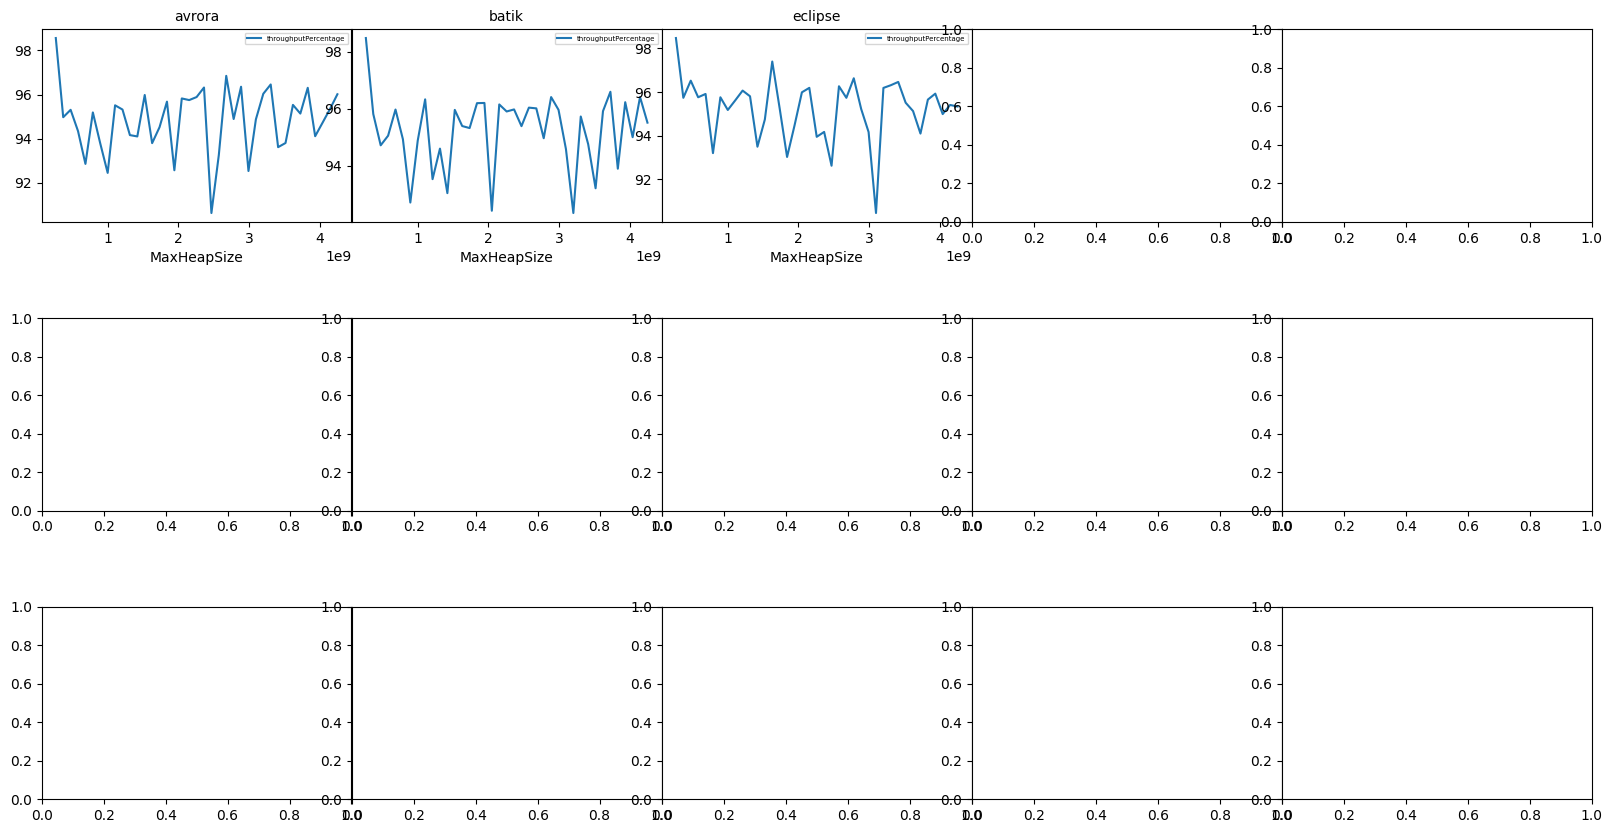

In [ ]:
def get_goal_value(goal_name: str, gc_log_file: str, api_key: str, verbose: bool=False):

    gceasy_url = f"https://api.gceasy.io/analyzeGC?apiKey={api_key}&normalizeUnits=true"
    gc_logfile = {"upload_file": open(gc_log_file, 'rb')}
    headers = {"Content-Type": "text"}

    response = requests.post(gceasy_url, files=gc_logfile, headers=headers)
    gc_info = json.loads(response.text)
    goal_value = gc_info[goal_name]

    if verbose: logging.debug(f"{goal_name} = {goal_value}")

    return float(goal_value)

bms = ["avrora","batik","eclipse", "fop", "h2", "jython", "luindex", "lusearch", "lusearch-fix", "pmd", "sunflow", "tomcat", "tradebeans", "tradesoap", "xalan"]

fig, axs = plt.subplots(3, 5, figsize=(20, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

# for i in range(len(bms)):
for i in range(3):

    # Measurements
    gc_values = []
    heap_values = []

    for Xmx in tqdm(range(268435456, 4294967296, 100 * (2**10) * (2**10))):
        env._run(
            jvm_opts = [f"-XX:MaxHeapSize={Xmx}"], 
            gc_log_file = GC_LOG_FILE, 
            bm = BM, 
            bm_path = BM_PATH, 
            n = 3
        )
        
        gc_value = get_goal_value(
            goal_name = "throughputPercentage", 
            gc_log_file = GC_LOG_FILE, 
            api_key = API_KEY
        )

        gc_values.append(gc_value)
        heap_values.append(Xmx)
    
    # Plots
    axs[i].plot(heap_values, gc_values, label='throughputPercentage')
    axs[i].legend(fontsize = 5)
    axs[i].set_xlabel(JVM_OPT_NAME, fontsize = 10)
    axs[i].set_title(bms[i], fontsize = 10)

# plt.plot(heap_values, fullgc_values, label='minorGCMaxTime')
# plt.plot(heap_values, minorgc_values, label='fullGCMaxTime')
# plt.legend()
# plt.xlabel(JVM_OPT_NAME)
# plt.title(BM)
# plt.show()

# Deep Learning Model

In [ ]:
env = JVMEnvTest.JVMEnvTest()

states = env.observation_space.shape
actions = env.action_space.n

print(states)
print(actions)

model = build_model(states, actions)
model.summary()

In [ ]:
# episodes = 3
# for episode in tqdm(range(1, episodes+1)):
#     state = env.reset()
#     done = False
#     score = 0

#     while not done:
#         env.render(mode="human")
#         action = env.action_space.sample()
#         n_state, reward, done, info = env.step(action)
#         score+=reward
#     #     print(info)
#     #     print(f"Score: {score}")
#     # print('Episode:{} Score:{}'.format(episode, score))

# Tensorflow DQN

In [1]:
import tensorflow as tf
from tqdm import tqdm
import imageio
import os
import numpy as np

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network, sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
import logging

# logging.basicConfig(level=logging.DEBUG)

# env_name = "CartPole-v1" # @param {type:"string"}
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

# JDK used for benchmarking
# TEST_JDK_PATH = "/Users/ellkrauze/projects/gc-ml/jdk-11.0.20.1.jdk"
TEST_JDK_PATH = "D:\projects\gc-ml\jdk-11.0.20.1"

# DaCapo benchmark name
# BM = "avrora"
BM = "xalan"
BM_TEST = "avrora"
BM_PATH = "dacapo-bench.jar"

# from PyEnvironments import CurveEnv, CurveMultipleEnv, JVMEnv
from PyEnvironments import JVMEnv

env = JVMEnv(
    jdk=TEST_JDK_PATH, 
    bm_path=BM_PATH, 
    bm=BM, 
    verbose=True
)
train_env = tf_py_environment.TFPyEnvironment(env)

env_e = JVMEnv(
    jdk=TEST_JDK_PATH, 
    bm_path=BM_PATH, 
    bm=BM_TEST, 
    verbose=True
)
eval_env = tf_py_environment.TFPyEnvironment(env_e)

Successfully initialized a JVM Environment!
 JDK: D:\projects\gc-ml\jdk-11.0.20.1\bin,
 Benchmark: xalan (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxHeapSize': {'min': 64000000.0, 'max': 7290000000.0}, 'InitialHeapSize': {'min': 8000000.0, 'max': 250000000.0}},
 Env. default state: [list([6423576576, 402653184]) 0.00818],
 Env. default goal value: 0.00818,

Successfully initialized a JVM Environment!
 JDK: D:\projects\gc-ml\jdk-11.0.20.1\bin,
 Benchmark: avrora (dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxHeapSize': {'min': 64000000.0, 'max': 7290000000.0}, 'InitialHeapSize': {'min': 8000000.0, 'max': 250000000.0}},
 Env. default state: [list([6423576576, 402653184]) 0.00327],
 Env. default goal value: 0.00327,



In [2]:
from tf_agents.policies import policy_saver

tempdir = "tmp"
# if os.path.exists(tempdir):
#     os.remove(tempdir)

checkpoint_dir = os.path.join(tempdir, 'checkpoint')
policy_dir = os.path.join(tempdir, 'policy')

In [3]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    """
    Define a helper function to create Dense layers configured 
    with the right activation and kernel initializer.
    """
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])


We also need an `optimizer` to train the network we just created, and a `train_step_counter` variable to keep track of how many times the network was updated.

Note that one other significant difference from vanilla `DqnAgent` is that we now need to specify `min_q_value` and `max_q_value` as arguments. These specify the most extreme values of the support (in other words, the most extreme of the 51 atoms on either side). Make sure to choose these appropriately for your particular environment. Here we use -20 and 20.

In [4]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)
global_step = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    epsilon_greedy=0.1, # a probability of choosing a random action
    gamma=gamma,
    train_step_counter=global_step)
    
agent.initialize()

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode, and we usually average this over a few episodes. We can compute the average return metric as follows.


In [5]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in tqdm(range(num_episodes)):
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      try:
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
        # print(f"{_}: {time_step.observation}, {time_step.reward}")
      except Exception:
        pass
      # print(time_step)
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

random_policy = random_tf_policy.RandomTFPolicy(
  train_env.time_step_spec(),
  train_env.action_spec()
)

# compute_avg_return(eval_env, random_policy, num_eval_episodes)

# compute_avg_return(eval_env, agent.policy, num_eval_episodes)

# https://github.com/tensorflow/agents/blob/master/tf_agents/metrics/py_metrics.py

## Data Collection

In order to keep track of the data collected from the environment, we will use a replay buffer. It stores experience data when we collect trajectories and is consumed during training.

This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using `agent.collect_data_spec`.

Set up the replay buffer and the initial data collection with the random policy.

In [6]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

tf_policy_saver = policy_saver.PolicySaver(agent.policy)

def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    try:
        next_time_step = environment.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        # Add trajectory to the replay buffer
        replay_buffer.add_batch(traj)
    except ValueError:
        pass

2023-09-08 13:38:42-ENV-INFO-Checkpoint available: tmp\checkpoint\ckpt-15000


In [ ]:
for _ in tqdm(range(initial_collect_steps)):
# for _ in tqdm(range(100)):
    collect_step(train_env, random_policy)

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

## Training the agent

The training loop involves both collecting data from the environment and optimizing the agent's networks. Along the way, we will occasionally evaluate the agent's policy to see how we are doing.

In [7]:
tf.config.run_functions_eagerly(True)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
# avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
# returns = [avg_return]

loss = []
# num_iterations = 100
for _ in tqdm(range(num_iterations)):
# for _ in tqdm(range(5000)):

  # # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy)
  # collect_driver.run()

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()
  # print(step)

  # if step % log_interval == 0:
  if step == (num_iterations / 20):
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))
    loss.append(train_loss.loss)

  # if step % eval_interval == 0:
  #   avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
  #   print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
  #   returns.append(avg_return)

  0%|          | 0/15000 [00:00<?, ?it/s]2023-09-07 17:10:55-ENV-DEBUG-[STEP] {'MaxHeapSize': 6423576576.0, 'InitialHeapSize': 250000000.0}, current_goal_value: 0.00533, reward: 0.21502209131075115


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


2023-09-07 17:10:55-ENV-WARNING-From d:\projects\gc-ml-env\lib\site-packages\tensorflow\python\util\dispatch.py:1176: calling foldr_v2 (from tensorflow.python.ops.functional_ops) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
  0%|          | 1/15000 [00:00<26:44,  9.35it/s]2023-09-07 17:10:55-ENV-DEBUG-[STEP] {'MaxHeapSize': 6423576576.0, 'InitialHeapSize': 250000000.0}, current_goal_value: 0.00533, reward: 0.21502209131075115
2023-09-07 17:10:55-ENV-DEBUG-[STEP] {'MaxHeapSize': 6423576576.0, 'InitialHeapSize': 250000000.0}, current_goal_value: 0.00533, reward: 0.21502209131075115
2023-09-07 17:10:55-ENV-DEBUG-[STEP] {'MaxHeapSize': 6528434176.0, 'InitialHeapSize': 250000000.0}, current_goal_value: 0.00571, reward: 0.159057437

step = 750: loss = 973642268672.0


2023-09-07 17:17:00-ENV-DEBUG-[STEP] {'MaxHeapSize': 6528434176.0, 'InitialHeapSize': 112857600.0}, current_goal_value: 0.00578, reward: 0.14874815905743735
  5%|▌         | 757/15000 [06:04<07:51, 30.21it/s]2023-09-07 17:17:00-ENV-DEBUG-[STEP] {'MaxHeapSize': 6633291776.0, 'InitialHeapSize': 112857600.0}, current_goal_value: 0.00596, reward: 0.12223858615611193
2023-09-07 17:17:05-ENV-DEBUG-[STEP] {'MaxHeapSize': 6738149376.0, 'InitialHeapSize': 112857600.0}, current_goal_value: 0.019, reward: -1.7982326951399115
2023-09-07 17:17:05-ENV-DEBUG-[STEP] {'MaxHeapSize': 6843006976.0, 'InitialHeapSize': 112857600.0}, current_goal_value: 0.0054, reward: 0.2047128129602356
2023-09-07 17:17:05-ENV-DEBUG-[STEP] {'MaxHeapSize': 6843006976.0, 'InitialHeapSize': 8000000.0}, current_goal_value: 0.0104, reward: -0.5316642120765831
  5%|▌         | 761/15000 [06:09<1:39:09,  2.39it/s]2023-09-07 17:17:05-ENV-DEBUG-[STEP] {'MaxHeapSize': 6843006976.0, 'InitialHeapSize': 8000000.0}, current_goal_value: 

Save to checkpoint.

In [13]:
train_checkpointer.save(global_step)

## Visualization


### Plots

We can plot return vs global steps to see the performance of our agent. In `Cartpole-v1`, the environment gives a reward of +1 for every time step the pole stays up, and since the maximum number of steps is 500, the maximum possible return is also 500.

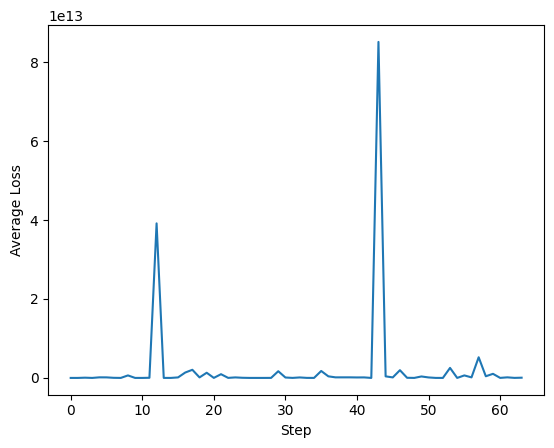

In [14]:
#@test {"skip": true}
import matplotlib.pyplot as plt

# steps = range(0, num_iterations, log_interval)
# plt.plot(steps, returns)
# plt.plot(steps, loss)
# plt.plot(loss)
plt.plot(train_loss[1][0].numpy())
# plt.plot(returns)
plt.ylabel('Average Loss')
plt.xlabel('Step')
# plt.ylim(top=550)
plt.show()

### Restore checkpoint

In [7]:
def run_episodes(policy, eval_tf_env, eval_py_env, num_episodes: int=10):
    # frames = []
    total_return = 0.0
    for _ in range(num_episodes):
        episode_return = 0.0
        time_step = eval_tf_env.reset()
        # frames.append(eval_py_env.render())
        threshold = 0
        while not time_step.is_last():
            if threshold > 10:
                break
            action_step = policy.action(time_step)
            time_step = eval_tf_env.step(action_step.action)
            # frames.append(eval_py_env.render())
            print(time_step.reward)
            episode_return += time_step.reward
            threshold += 1
        total_return += episode_return

    avg_return = total_return / num_episodes

    print(total_return)
    print(avg_return)
    return avg_return.numpy()[0]

# The whole set of objects should be recreated 
# the same way as when the checkpoint was created.
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

# Also save policy and export to a location
tf_policy_saver.save(policy_dir)

# The policy can be loaded without having any knowledge 
# of what agent or network was used to create it. 
# This makes deployment of the policy much easier.
# Load the saved policy and check how it performs.
saved_policy = tf.saved_model.load(policy_dir)
# reward = run_episodes(saved_policy, eval_env, env, num_episodes=1)
# print(reward)

saved_res = compute_avg_return(eval_env, saved_policy, num_episodes=20)
# random_res = compute_avg_return(eval_env, random_policy, num_episodes=20)

2023-09-08 12:49:04-ENV-INFO-Function `function_with_signature` contains input name(s) 0/step_type, 0/reward, 0/discount, 0/observation, 511, 513, 515, 517, 519, 521 with unsupported characters which will be renamed to step_type, reward, discount, observation, unknown, unknown_0, unknown_1, unknown_2, unknown_3, unknown_4 in the SavedModel.
2023-09-08 12:49:04-ENV-WARNING-`0/step_type` is not a valid tf.function parameter name. Sanitizing to `arg_0_step_type`.
2023-09-08 12:49:04-ENV-WARNING-`0/reward` is not a valid tf.function parameter name. Sanitizing to `arg_0_reward`.
2023-09-08 12:49:04-ENV-WARNING-`0/discount` is not a valid tf.function parameter name. Sanitizing to `arg_0_discount`.
2023-09-08 12:49:04-ENV-WARNING-`0/observation` is not a valid tf.function parameter name. Sanitizing to `arg_0_observation`.


2023-09-08 12:49:04-ENV-WARNING-`0/step_type` is not a valid tf.function parameter name. Sanitizing to `arg_0_step_type`.
2023-09-08 12:49:04-ENV-INFO-Function `function_with_signature` contains input name(s) 558 with unsupported characters which will be renamed to unknown in the SavedModel.
d:\projects\gc-ml-env\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:475: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: tmp\policy\assets


2023-09-08 12:49:04-ENV-INFO-Assets written to: tmp\policy\assets
  0%|          | 0/20 [00:00<?, ?it/s]2023-09-08 12:49:04-ENV-DEBUG-[RESET] {'MaxHeapSize': 6423576576, 'InitialHeapSize': 402653184}, target: 0.00304
2023-09-08 12:49:22-ENV-DEBUG-[STEP] {'MaxHeapSize': 6423576576.0, 'InitialHeapSize': 250000000.0}, current_goal_value: 0.00312, reward: -0.026315789473684136
2023-09-08 12:49:40-ENV-DEBUG-[STEP] {'MaxHeapSize': 6528434176.0, 'InitialHeapSize': 250000000.0}, current_goal_value: 0.00296, reward: 0.02631578947368428
2023-09-08 12:49:57-ENV-DEBUG-[STEP] {'MaxHeapSize': 6633291776.0, 'InitialHeapSize': 250000000.0}, current_goal_value: 0.00298, reward: 0.01973684210526321
2023-09-08 12:50:17-ENV-DEBUG-[STEP] {'MaxHeapSize': 6738149376.0, 'InitialHeapSize': 250000000.0}, current_goal_value: 0.00334, reward: -0.09868421052631576
2023-09-08 12:50:37-ENV-DEBUG-[STEP] {'MaxHeapSize': 6843006976.0, 'InitialHeapSize': 250000000.0}, current_goal_value: 0.00312, reward: -0.026315789473

## Test agent

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x22788bdaeb0>

In [15]:
# eval_env.reset()

state = np.array([[6423576576, 402653184], 0.00578], dtype=object)
saved_policy[state]
# q_values = saved_policy.

TypeError: '_UserObject' object is not subscriptable

In [11]:
time_step = eval_env.current_time_step['observation']

TypeError: 'method' object is not subscriptable

## Keras-rl2 DQNAgent

In [ ]:
import tensorflow as tf
print(tf.__version__)
from keras import __version__
tf.keras.__version__ = __version__

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

import matplotlib.pyplot as plt
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import ModelIntervalCheckpoint, FileLogger


def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, 2)))
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    # model.add(Flatten())
    return model
    
def build_callbacks(env_name):
    checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
    log_filename = 'dqn_{}_log.json'.format(env_name)
    callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=5000)]
    callbacks += [FileLogger(log_filename, interval=100)]
    return callbacks

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

LEARNING_RATE = 0.1
GAMMA = 0.9999

callbacks = build_callbacks("gc")

# policy = BoltzmannQPolicy()
policy = EpsGreedyQPolicy()
# memory = SequentialMemory(limit=50000, window_length=1)

# memory can help a model during training
# for this, we only consider a single malware sample (window_length=1) for each "experience"
memory = SequentialMemory(limit=50000, window_length=1)

# DQN agent as described in Mnih (2013) and Mnih (2015).
# http://arxiv.org/pdf/1312.5602.pdf
# http://arxiv.org/abs/1509.06461
dqn = DQNAgent(
    model=model, 
    memory=memory, 
    policy=policy,
    nb_actions=actions, 
    nb_steps_warmup=10, 
    target_model_update=1e-2, 
    batch_size=16,
    gamma=GAMMA
)

# keras-rl allows one to use and built-in keras optimizer
dqn.compile(Adam(lr=LEARNING_RATE), metrics=['mae'])

history = dqn.fit(env, nb_max_episode_steps=100, nb_steps=50000, visualize=False, verbose=1)

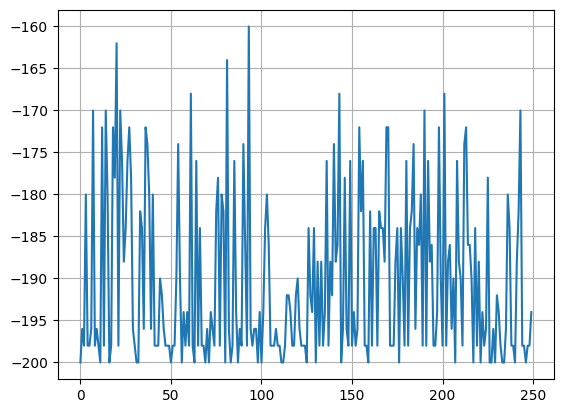

In [ ]:
import matplotlib.pyplot as plt 
plt.grid(True)
plt.plot(history.history['episode_reward'])

In [ ]:
# scores = dqn.test(env, nb_episodes=100, visualize=False)

# scores = dqn.test(
#     env, 
#     nb_episodes=1,
#     visualize=False, 
#     verbose=1
# )

scores = dqn.test(
    env,
    nb_episodes=100,
    action_repetition=1,
    nb_max_episode_steps=200,
    visualize=False,
    verbose=1
)

# print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: -200.000, steps: 200
Episode 2: reward: -198.000, steps: 200
Episode 3: reward: -200.000, steps: 200
Episode 4: reward: -200.000, steps: 200
Episode 5: reward: -196.000, steps: 200
Episode 6: reward: -198.000, steps: 200
Episode 7: reward: -198.000, steps: 200
Episode 8: reward: -200.000, steps: 200
Episode 9: reward: -198.000, steps: 200
Episode 10: reward: -198.000, steps: 200
Episode 11: reward: -196.000, steps: 200
Episode 12: reward: -198.000, steps: 200
Episode 13: reward: -198.000, steps: 200
Episode 14: reward: -198.000, steps: 200
Episode 15: reward: -198.000, steps: 200
Episode 16: reward: -200.000, steps: 200
Episode 17: reward: -200.000, steps: 200
Episode 18: reward: -200.000, steps: 200
Episode 19: reward: -198.000, steps: 200
Episode 20: reward: -200.000, steps: 200
Episode 21: reward: -200.000, steps: 200
Episode 22: reward: -198.000, steps: 200
Episode 23: reward: -198.000, steps: 200
Episode 24: reward: -200.000, steps: 

KeyboardInterrupt: 

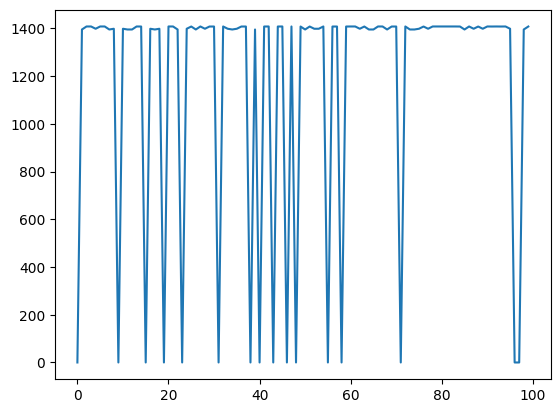

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(scores.history['episode_reward'])

In [ ]:
_ = dqn.test(env, nb_episodes=15, visualize=False)

DONE
{'agent': array([  2., -19.]), 'target': array([  1.99999998, -19.        ])}


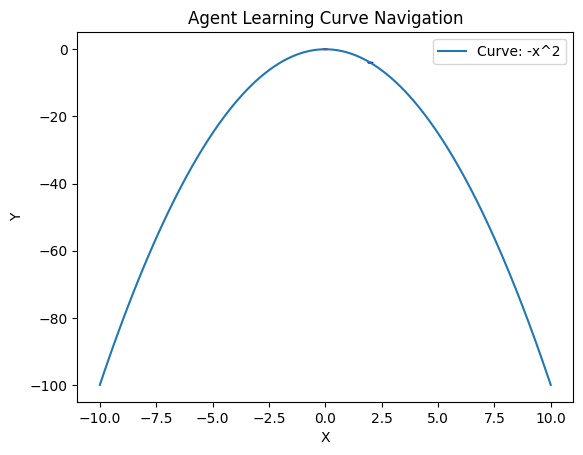

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

{'agent': array([ 3., -8.]), 'target': array([  2., -19.])}


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# from gym.envs.classic_control import rendering
import math

def visualize_learning_realtime(agent, env):
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots()

    x_vals = np.linspace(-10, 10, 400)
    y_vals = [2*math.pow(x, 3) - 3*math.pow(x, 2) - 12 * x + 1 for x in x_vals]
    target_x = 0

    agent_x = env._agent_location[0]

    line, = ax.plot(x_vals, y_vals, label="Curve: -x^2")
    target_circle = plt.Circle((target_x, 0), 0.1, color='red')
    agent_circle = plt.Circle((agent_x, -agent_x ** 2), 0.1, color='blue')

    ax.add_patch(target_circle)
    ax.add_patch(agent_circle)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Agent Learning Curve Navigation')
    ax.legend()

    plt.draw()

    for _ in range(200):
        action = agent.forward(env.observation_space.sample())  # Replace with your agent's action selection
        observation, reward, done, _ = env.step(action)

        agent_x = observation[0]

        agent_circle.center = (agent_x, -agent_x ** 2)
        plt.pause(0.01)
        plt.draw()

        if done:
            env.reset()

    plt.ioff()
    plt.show()

visualize_learning_realtime(dqn, env)

## Save and load

In [ ]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
# env = gym.make('CartPole-v0')
actions = env.action_space.n
states = env.observation_space.shape[0]
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights.h5f')

In [ ]:
_ = dqn.test(env, nb_episodes=5, visualize=True)

## Parameters

* ParallelGCThreads: int
* MaxGCPauseMillis: int
* GCTimeRatio: int
* MaxHeapSize: int
* InitialHeapSize: int
* YoungGenerationSizeIncrement: int
* TenuredGenerationSizeIncrement: int
* AdaptiveSizeDecrementScaleFactor: int
* ParallelGCBufferWastePct: int
* ParallelOldDeadWoodLimiterMean: int
* ParallelOldDeadWoodLimiterStdDev: int
* PreTouchParallelChunkSize: int

* UseGCOverheadLimit: bool
* ParallelRefProcBalancingEnabled: bool
* ParallelRefProcEnabled: bool
* AllowParallelDefineClass: bool
* CMSParallelInitialMarkEnabled: bool
* CMSParallelRemarkEnabled: bool
* CMSParallelSurvivorRemarkEnabled: bool
* GCParallelVerificationEnabled: bool